## Import required libraries

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

import re
import nltk 
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings("ignore")

# Download necessary NLTK data
nltk.download("stopwords")
nltk.download("punkt")

import pickle


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jojo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jojo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading the Dataset

In [3]:
# Load the dataset
df = pd.read_csv('data/IMDB Dataset.csv')
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [5]:
df.shape

(50000, 2)

In [6]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Data Exploration

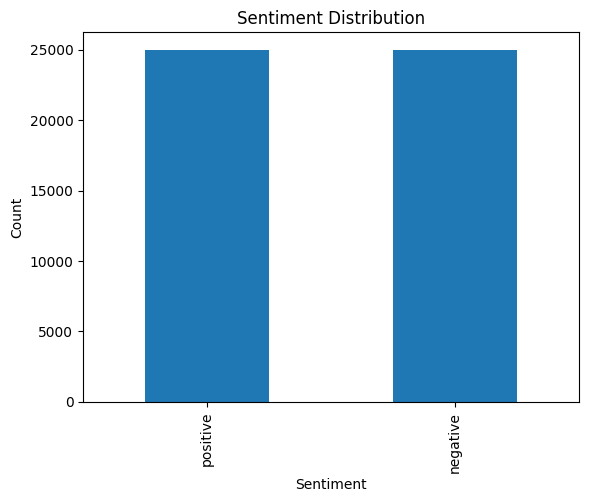

In [8]:
# Distribution of sentiment labels
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


## Data Preprocessing

- Removing punctuation from the data.
- Eliminating unnecessary symbols in the dataset.
- Converting text to lowercase.
- Removing extra spaces.
- Filtering out stopwords from sentences.

In [9]:
# Cleaning the review
df['review'] = df['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
df['review'] = df['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))
df['review'] = df['review'].apply(lambda x: x.lower())
df['review'] = df['review'].apply(lambda x: x.strip())

In [10]:
stopwords = set(stopwords.words('english'))
print (f"number of words in our stopwords list: {len(stopwords)}")

number of words in our stopwords list: 179


In [11]:
sentiment = df['sentiment'].values
review = df['review']

In [12]:
# Map sentiment labels to binary
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [13]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the ...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1


## Split the Train and Test data and Tokenize the "reviews"

In [14]:
# Train and Test Split Data
x_train, x_test, y_train, y_test = train_test_split(review,sentiment,test_size = 0.2, random_state = 42)

# Tokenization
tokenizer = Tokenizer(num_words = 15000)
tokenizer.fit_on_texts(review)

# Convert tokens to sequences of integers
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

# Determine the number of tokens per review 
n_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
n_tokens = np.array(n_tokens)

# Determine the maximum number of tokens 
tokens = np.mean(n_tokens) + 2 * np.std(n_tokens)
tokens = int(tokens)
tokens

567

In [15]:
np.sum(n_tokens < tokens) / len(n_tokens)

0.94524

In [16]:
#data is adjusted according to the number of tokens specified
x_train_pad_sequences = pad_sequences(x_train_tokens, maxlen=tokens)
x_test_pad_sequences = pad_sequences(x_test_tokens, maxlen=tokens)

x_train_pad_sequences.shape

(40000, 567)

In [17]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [22]:
print(return_to_sentence(x_train_pad_sequences[0]))

that s what i kept asking myself during the many fights screaming matches swearing and general mayhem that the minutes the comparisons also stand up when you think of the one dimensional characters who have so little depth that it is virtually impossible to care what happens to them they are just badly written for the director to hang his beliefs on a topic that has been done much better in other dramas both on tv and the cinema br br i must confess i m not really one for spotting bad performances during a film but it must be said that as the heroine s slutty best friend and as the nasty bullying brother were absolutely terrible i don t know what acting school they graduated from but if i was them i d apply for a full refund post only in the lead role manages to impress in a cast of so called british talent that we ll probably never hear from again at least that s the hope next time hire a different scout br br another intriguing thought is the hideously fashionable soundtrack featurin

In [19]:
# Map the sentiment class accordingly
y_train = np.array(y_train)
label_mapping = {'negative': 0, 'positive': 1}
y_train_numeric = np.array([label_mapping[label] for label in y_train])

# Convert to float
y_train_numeric = y_train_numeric.astype('float32')

# Ensure features data is in the correct format
x_train_pad = np.array(x_train_pad_sequences)
if x_train_pad.dtype != 'int32':
    x_train_pad = x_train_pad.astype('int32')

# Print data types for verification
print(f"x_train_pad dtype: {x_train_pad.dtype}")
print(f"y_train_numeric dtype: {y_train_numeric.dtype}")
print(f"Unique values in y_train_numeric: {np.unique(y_train_numeric)}")

x_train_pad dtype: int32
y_train_numeric dtype: float32
Unique values in y_train_numeric: [0. 1.]


## Building the RNN Model
* Setup the RNN and it's layers
* Build the model and the optimizer to use

In [32]:
# Create the model and add layers
model = Sequential()
model.add(Embedding(input_dim=15000, output_dim=128, input_length=tokens))
model.add(LSTM(128, return_sequences=True))
#model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=1e-3)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the model
model.build((None, tokens))

# Print model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 567, 128)       │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 567, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,101,057 (8.01 MB)

 Trainable params: 2,101,057 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

In [33]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Proceed with training
training = model.fit(x_train_pad, y_train_numeric, validation_split=0.3, epochs=5, batch_size=1000, shuffle=True, verbose=1 ,callbacks=[early_stopping])

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.5689 - loss: 0.6854 - val_accuracy: 0.6403 - val_loss: 0.6418
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.6914 - loss: 0.5898 - val_accuracy: 0.8057 - val_loss: 0.4291
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.8448 - loss: 0.3702 - val_accuracy: 0.8531 - val_loss: 0.3495
Epoch 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.8970 - loss: 0.2634 - val_accuracy: 0.8744 - val_loss: 0.3207
Epoch 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.9317 - loss: 0.1900 - val_accuracy: 0.8649 - val_loss: 0.3261


* Initial Performance: In the first epoch, the model starts with an accuracy of 56.89% and a loss of 0.6854, indicating that it initially struggles with the classification task, which is typical in the early stages of training.

* Significant Improvement in Accuracy: The model shows a marked improvement in accuracy, reaching 93.17% by the fifth epoch. This steady increase suggests that the model is effectively learning from the training data.

* Validation Accuracy Trends: The validation accuracy increases from 64.03% in Epoch 1 to 87.44% in Epoch 4, before slightly dropping to 86.49% in Epoch 5. This slight drop could be an early indicator of overfitting, where the model performs slightly worse on unseen data despite continuing to improve on the training data.

* Consistent Decrease in Loss: Both training and validation losses consistently decrease over the epochs. The training loss decreases from 0.6854 to 0.1900, while the validation loss decreases from 0.6418 to 0.3207 by Epoch 4, then slightly increases to 0.3261 in Epoch 5. This pattern further indicates that the model is fitting the data well, but the slight increase in validation loss at the end might suggest overfitting.

* Convergence and Stability: The model seems to be converging well, with both the accuracy and loss stabilizing by the fifth epoch. The small changes in validation accuracy and loss in the last epoch suggest that the model has learned the patterns in the data and is close to its optimal performance.

## Evaluating the Model

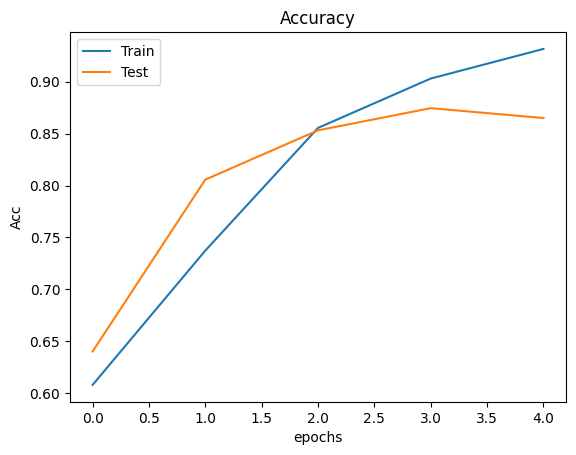

In [34]:
# Plotting the training accuracy
plt.figure()
plt.plot(training.history["accuracy"], label = "Train")
plt.plot(training.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

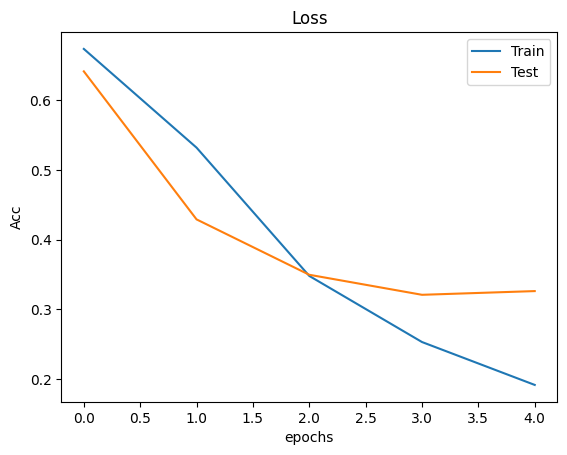

In [35]:
# Plotting the results loss
plt.figure()
plt.plot(training.history["loss"], label = "Train")
plt.plot(training.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

## Hyperparameter Tuning

In [36]:
# Example of changing hyperparameters
tuned_model = Sequential()
tuned_model.add(Embedding(input_dim=15000, output_dim=128, input_length=tokens))

# Changed number of units
tuned_model.add(LSTM(128, return_sequences=True))  

 # Added dropout for regularization
tuned_model.add(Dropout(0.5)) 
tuned_model.add(LSTM(64))
tuned_model.add(Dense(1, activation='sigmoid'))

# Compile and train with new hyperparameters
tuned_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build the model
tuned_model.build((None, tokens))

# Print model summary
tuned_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 567, 128)       │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 567, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 567, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,101,057 (8.01 MB)

 Trainable params: 2,101,057 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

## Train the tuned model after making changes to the parameters

In [37]:
# Proceed with training
tuned_training = tuned_model.fit(x_train_pad, y_train_numeric, validation_split=0.3, epochs=5, batch_size=1000, shuffle=True, verbose=1 ,callbacks=[early_stopping])

Epoch 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.5619 - loss: 0.6910 - val_accuracy: 0.6808 - val_loss: 0.6199
Epoch 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.7427 - loss: 0.5624 - val_accuracy: 0.8007 - val_loss: 0.4501
Epoch 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.8296 - loss: 0.3976 - val_accuracy: 0.8413 - val_loss: 0.3768


## Comparative Analysis

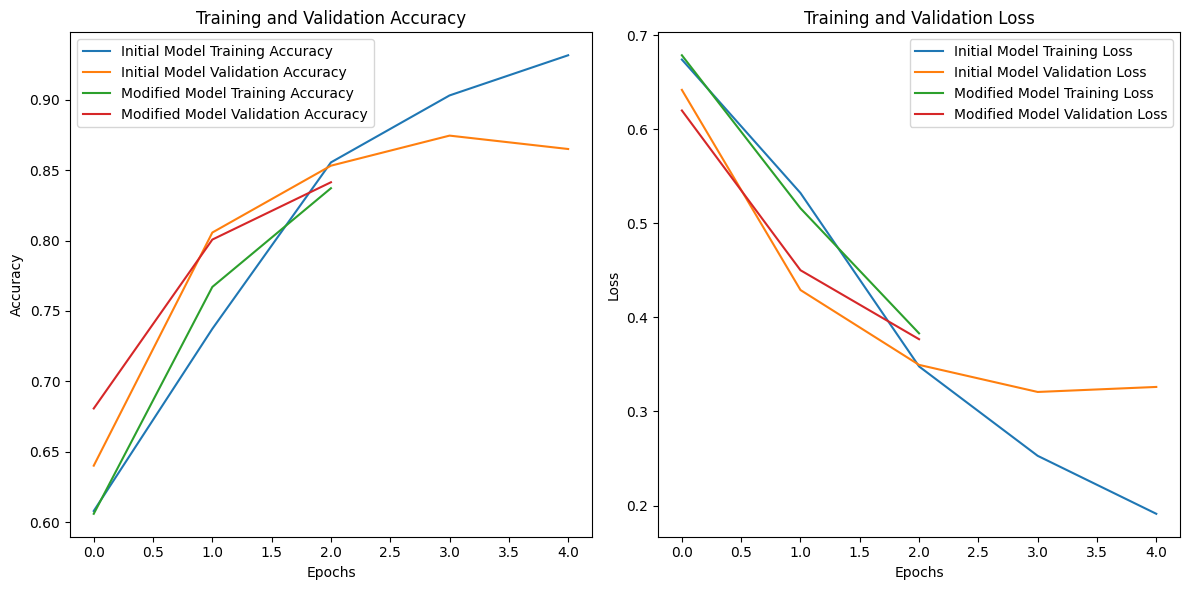

In [38]:
# Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training.history['accuracy'], label='Initial Model Training Accuracy')
plt.plot(training.history['val_accuracy'], label='Initial Model Validation Accuracy')
plt.plot(tuned_training.history['accuracy'], label='Modified Model Training Accuracy')
plt.plot(tuned_training.history['val_accuracy'], label='Modified Model Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(training.history['loss'], label='Initial Model Training Loss')
plt.plot(training.history['val_loss'], label='Initial Model Validation Loss')
plt.plot(tuned_training.history['loss'], label='Modified Model Training Loss')
plt.plot(tuned_training.history['val_loss'], label='Modified Model Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

* Improved Initial Validation Accuracy: The validation accuracy in the first epoch is 68.08%, which is higher compared to the initial results before hyperparameter tuning. This suggests that the hyperparameters are better suited for the model, leading to a stronger starting point.

* Better Generalization: The validation accuracy steadily increases from 68.08% in Epoch 1 to 84.13% in Epoch 3, with corresponding decreases in validation loss. This indicates that the model is generalizing better to unseen data after the hyperparameter tuning.

* Steady Improvement in Training Accuracy: The training accuracy improves from 56.19% in Epoch 1 to 82.96% in Epoch 3. This consistent improvement, along with the decreasing training loss, suggests that the model is learning more effectively with the tuned parameters.

* Reduced Overfitting: Compared to the previous training, the validation accuracy and loss show less fluctuation, indicating that the hyperparameter tuning has likely reduced overfitting, allowing the model to maintain performance on the validation set without significant degradation.

In [49]:
x_train_pad

array([[   0,    0,    0, ...,  201,  352, 3893],
       [   0,    0,    0, ...,   23,  104,    8],
       [   0,    0,    0, ...,    2,  700,   65],
       ...,
       [   0,    0,    0, ..., 1596,    2,  597],
       [   0,    0,    0, ...,  104,  127, 7328],
       [   0,    0,    0, ...,   70,   74, 1962]])

In [50]:
y_train_numeric

array([0., 0., 1., ..., 0., 1., 1.], dtype=float32)

In [51]:
tuned_model.evaluate(x_train_pad, y_train_numeric)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 98ms/step - accuracy: 0.8766 - loss: 0.3172


[0.3351673185825348, 0.8658249974250793]

## Saving the Model and the Tokenizer

In [52]:
# Save the model and the tokenizer
import pickle
tuned_model.save('tuned_model.keras')

# Save the tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)